# Decision Tree Classifier
### Importing data:

In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import scipy.stats as stats
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
%matplotlib inline

In [2]:
violations = pd.read_pickle('data/violations.pkl')

In [3]:
violations = violations[violations.delay > 21].sample(frac = 1)
X = violations.drop([
        'date', 'restaurant_id', '*', '**', '***', 'name', 'reviews', 'rating', 'delay'
    ],1)
y = (violations['*'] + violations['**'] + violations['***'] > 0).values.astype(np.int)

### Cross-validated hyperparameter tuning:

In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=.8, stratify = y)
gs = GridSearchCV(
        estimator = DecisionTreeClassifier(),
        param_grid = {
            'min_samples_leaf' : np.arange(1, 10, 1),
            'max_features' : np.arange(35, 48, 1),
            'max_depth' : np.arange(1, 12, 1)
        },
        n_jobs = -1
)
gs.fit(Xtrain, ytrain)
clf = gs.best_estimator_
export_graphviz(clf, out_file='tree1.dot', feature_names = Xtrain.columns) 
gs.best_params_

{'max_depth': 6, 'max_features': 37, 'min_samples_leaf': 6}

### Evaluation:
* Accuracies on training and test sets
* ROC curve and its AUC
* Precision-recall curve and its AUC
* Learning curve

In [5]:
clf.score(Xtrain, ytrain), clf.score(Xtest, ytest)

(0.86111888111888113, 0.8383668903803132)

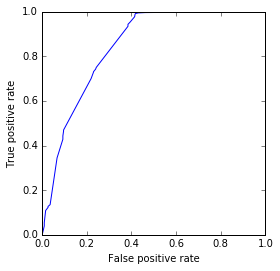

0.84368908382066288

In [6]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
plt.rcParams['figure.figsize'] = (4, 4)
xroc, yroc, _ = roc_curve(ytest, clf.predict_proba(Xtest)[:,1])
plt.plot(xroc, yroc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
auc(xroc,yroc)

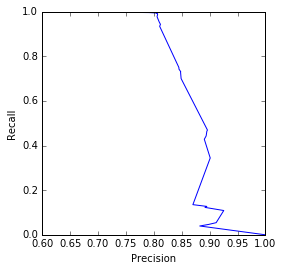

0.87019961662369449

In [7]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
xprc, yprc, _ = precision_recall_curve(ytest, clf.predict_proba(Xtest)[:,1])
plt.plot(xprc, yprc)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()
average_precision_score(ytest, clf.predict_proba(Xtest)[:,1])

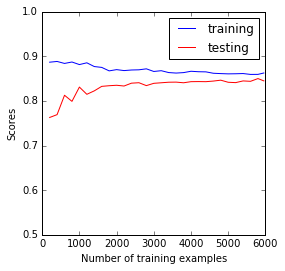

In [8]:
from sklearn.learning_curve import learning_curve
train_size, train_score, test_score = learning_curve(
    clf, 
    X, 
    y, 
    n_jobs = -1,
    train_sizes = np.hstack((np.arange(200, 6000, 200), 5958))
)
plt.plot(
    train_size, 
    train_score.mean(axis = 1), 
    label='training'
)
plt.plot(
    train_size, 
    test_score.mean(axis = 1), 
    label='testing', c='red'
)
plt.legend(loc = 0)
plt.ylim([0.5,1])
plt.xlabel('Number of training examples')
plt.ylabel('Scores')
plt.show()

### List of feature importances, and a new classifier using only the most important 5 features:


In [9]:
featurelist = pd.DataFrame()
featurelist['name'] = X.columns
featurelist['importance'] = clf.feature_importances_
featurelist.sort_values('importance', ascending = False)

,name,importance
11,Trees,0.578598
42,Pothole,0.151361
3,Highway Maintenance,0.138451
0,latitude,0.027004
5,Street Lights,0.020481
38,Water Issues,0.016059
1,longitude,0.014338
10,Building,0.012834
14,Environmental Services,0.009368
18,Animal Issues,0.006622


In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X[featurelist.sort_values('importance', ascending = False).head(5).name], 
    y, train_size=.8, stratify = y
)
gs = GridSearchCV(
        estimator = DecisionTreeClassifier(),
        param_grid = {
            'min_samples_leaf' : np.arange(1, 10, 1),
            'max_features' : np.arange(1, 6, 1),
            'max_depth' : np.arange(1, 10, 1)
        },
        n_jobs = -1
)
gs.fit(Xtrain, ytrain)
clf = gs.best_estimator_
export_graphviz(clf, out_file='tree2.dot', feature_names = Xtrain.columns) 
gs.best_params_

{'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 3}

In [11]:
clf.score(Xtrain, ytrain), clf.score(Xtest, ytest)

(0.85748251748251747, 0.8383668903803132)